The steps in this hands-on tutorial about AWS Glue are the following:

Step 1. Enter credentials

Step 2. Create an S3 bucket and load the dataset into the bucket

Step 3. Create a database for the crawled data

Step 4. Create a service role, that will used to access S3 and use Glue features

Step 5. Create the crawler and run the crawl job

Step 6. Write a Pyspark file with the operations to be performed on the dataset

Step 7. Generate a file with ETL job and load it into the S3 bucket

Step 8. Configure the ETL Glue Job and run it manually

#### Enter credentials

In [1]:
import getpass

In [2]:
accessKeyID = getpass.getpass()

In [3]:
secretAccessKeyID = getpass.getpass()

#### Create an S3 bucket

In [38]:
import boto3

bucket='glue-test-az1-atomisu'
bucket_source='glue-test-az1-atomisu/raw_files'

session = boto3.Session(aws_access_key_id=accessKeyID,
                        aws_secret_access_key=secretAccessKeyID)

dev_s3_client = session.client('s3')

response = dev_s3_client.create_bucket(
      Bucket=bucket,
      CreateBucketConfiguration={
        'LocationConstraint': 'ap-northeast-1'  # 東京リージョンの場合
    })
print(response)

BucketAlreadyOwnedByYou: An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.

#### Upload local file to S3

In [5]:
fileToUpload = 'TSLA.csv'
dev_s3_client.upload_file(f'{fileToUpload}', 
                          bucket,
                          f'raw_files/{fileToUpload}')

Verify the file was uploaded.

In [7]:
response = dev_s3_client.list_objects(Bucket=f'{bucket}')

In [8]:
for key in response["Contents"]:
    print(key['Key'])

5e818379-1ad4-4418-ad35-a18482e72a6f.csv
5e818379-1ad4-4418-ad35-a18482e72a6f.csv.metadata
processed/TSLA.csv/part-00000-db5c53eb-dab9-4547-876e-d39c683e472d-c000.csv
processed_$folder$
raw_files/TSLA.csv
scripts/sparkETL.py


#### Create a database where the crawler can store the results

In [9]:
session = boto3.session.Session(aws_access_key_id=accessKeyID, aws_secret_access_key=secretAccessKeyID)
glue_client = session.client('glue', region_name='ap-northeast-1')

In [10]:
dbName = 'mydbaz1'
glue_client.create_database(DatabaseInput={'Name': dbName})

AlreadyExistsException: An error occurred (AlreadyExistsException) when calling the CreateDatabase operation: Database already exists.

#### Create a service role

In [11]:
import json

In [13]:
trust_policy={
  "Version": "2012-10-17",
  "Statement": [
    {
      "Sid": "",
      "Effect": "Allow",
      "Principal": {
        "Service": "glue.amazonaws.com"
      },
      "Action": "sts:AssumeRole"
    }
  ]
}

In [64]:
iam_client = session.client('iam')

In [15]:
iam_response = iam_client.create_role(RoleName = 'AWSGlueServiceRole-AZ1', 
                       AssumeRolePolicyDocument = json.dumps(trust_policy))

print(iam_response)

{'Role': {'Path': '/', 'RoleName': 'AWSGlueServiceRole-AZ1', 'RoleId': 'AROATQD5P33CKLNPP5FK6', 'Arn': 'arn:aws:iam::240781352644:role/AWSGlueServiceRole-AZ1', 'CreateDate': datetime.datetime(2025, 5, 15, 9, 49, 1, tzinfo=tzutc()), 'AssumeRolePolicyDocument': {'Version': '2012-10-17', 'Statement': [{'Sid': '', 'Effect': 'Allow', 'Principal': {'Service': 'glue.amazonaws.com'}, 'Action': 'sts:AssumeRole'}]}}, 'ResponseMetadata': {'RequestId': '268dcdb1-0da5-4237-8ca8-969c62ba771b', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Thu, 15 May 2025 09:49:01 GMT', 'x-amzn-requestid': '268dcdb1-0da5-4237-8ca8-969c62ba771b', 'content-type': 'text/xml', 'content-length': '823'}, 'RetryAttempts': 0}}


#### Attach the policy AWSGlueServiceRole to the new role

In [16]:
iam_client.attach_role_policy(RoleName="AWSGlueServiceRole-AZ1",
                              PolicyArn="arn:aws:iam::aws:policy/service-role/AWSGlueServiceRole")

{'ResponseMetadata': {'RequestId': 'd3ca2c9a-f4c8-4969-8fdf-5d8457f4797a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Thu, 15 May 2025 09:49:05 GMT',
   'x-amzn-requestid': 'd3ca2c9a-f4c8-4969-8fdf-5d8457f4797a',
   'content-type': 'text/xml',
   'content-length': '212'},
  'RetryAttempts': 0}}

In [17]:
iam_client.attach_role_policy(RoleName="AWSGlueServiceRole-AZ1",
                              PolicyArn="arn:aws:iam::aws:policy/AmazonS3FullAccess")

{'ResponseMetadata': {'RequestId': '3f55a3e3-0a0e-4edc-bd56-67f729cd59a8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Thu, 15 May 2025 09:49:08 GMT',
   'x-amzn-requestid': '3f55a3e3-0a0e-4edc-bd56-67f729cd59a8',
   'content-type': 'text/xml',
   'content-length': '212'},
  'RetryAttempts': 0}}

#### Create the crawler

The crawler needs to use the role *AWSGlueServiceRole-AZ1* that was created before.

In [39]:
import json

response = glue_client.create_crawler(Name='CrawlerAZ1_',
                                      Role='AWSGlueServiceRole-AZ1',
                                      DatabaseName = dbName,
                                      Targets={ 
                                          'S3Targets': [
                                              {
                                                  'Path': f's3://{bucket_source}',
                                              },
                                          ],
                                      },
                                      SchemaChangePolicy={
                                          'UpdateBehavior': 'UPDATE_IN_DATABASE',
                                          'DeleteBehavior': 'DEPRECATE_IN_DATABASE'
                                      },
                                      RecrawlPolicy={
                                          'RecrawlBehavior': 'CRAWL_EVERYTHING'
                                      },
                                      LineageConfiguration={
                                          'CrawlerLineageSettings': 'DISABLE'
                                      })

print(response)

{'ResponseMetadata': {'RequestId': '1ca5cacc-dd73-47ec-9eb8-f15dc733136f', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Tue, 20 May 2025 13:41:42 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '2', 'connection': 'keep-alive', 'x-amzn-requestid': '1ca5cacc-dd73-47ec-9eb8-f15dc733136f', 'cache-control': 'no-cache'}, 'RetryAttempts': 0}}


#### List crawlers

In [42]:
glue_client.list_crawlers()

{'CrawlerNames': ['Crawler-240781352644-ap-northeast-1',
  'CrawlerAZ1',
  'CrawlerAZ1_',
  'mysamplec'],
 'ResponseMetadata': {'RequestId': 'a5403326-0681-4c25-99a6-77b5ce8fa4bd',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Tue, 20 May 2025 13:42:20 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '95',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'a5403326-0681-4c25-99a6-77b5ce8fa4bd',
   'cache-control': 'no-cache'},
  'RetryAttempts': 0}}

The crawler I just created is present in the list

If the database doesn't exist it will be created.

#### Run the crawler manually

In [46]:
glue_client.start_crawler(Name = 'CrawlerAZ1_')

{'ResponseMetadata': {'RequestId': '7651cbfd-70a0-438f-9ccf-27ceb7eb0e0b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Tue, 20 May 2025 13:43:15 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '7651cbfd-70a0-438f-9ccf-27ceb7eb0e0b',
   'cache-control': 'no-cache'},
  'RetryAttempts': 0}}

#### Check crawler status

In [47]:
exit_v = 0
while not(exit_v):
    response = glue_client.get_crawler(Name = 'CrawlerAZ1_')
    if (response['Crawler']['State'] == 'STOPPING') or (response['Crawler']['State'] == 'READY'):
        exit_v = 1
        
response['Crawler']['State']

'READY'

Wait until it says **STOPPING** or **READY**.

#### See the generated table

The table get the name of the bucket it crawled.

In [48]:
response = glue_client.get_tables(DatabaseName=dbName)

table_name = response['TableList'][0]['Name']  # 最初のテーブル名を取得
response['TableList'][0]

{'Name': 'glue_test_az1_atomisu',
 'DatabaseName': 'mydbaz1',
 'Owner': 'owner',
 'CreateTime': datetime.datetime(2025, 5, 15, 18, 57, 46, tzinfo=tzlocal()),
 'UpdateTime': datetime.datetime(2025, 5, 20, 22, 28, 51, tzinfo=tzlocal()),
 'LastAccessTime': datetime.datetime(2025, 5, 20, 22, 28, 51, tzinfo=tzlocal()),
 'Retention': 0,
 'StorageDescriptor': {'Columns': [{'Name': 'date', 'Type': 'string'},
   {'Name': 'open', 'Type': 'double'},
   {'Name': 'high', 'Type': 'double'},
   {'Name': 'low', 'Type': 'double'},
   {'Name': 'close', 'Type': 'double'},
   {'Name': 'adj close', 'Type': 'double'},
   {'Name': 'volume', 'Type': 'bigint'}],
  'Location': 's3://glue-test-az1-atomisu/',
  'InputFormat': 'org.apache.hadoop.mapred.TextInputFormat',
  'OutputFormat': 'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat',
  'Compressed': False,
  'NumberOfBuckets': -1,
  'SerdeInfo': {'SerializationLibrary': 'org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe',
   'Parameters': {'field.d

As can be seen above the new table contains the columns corresponding to excel file columns.

#### Querying the database with AWS Athena

In [49]:
athena_client = session.client('athena', region_name='ap-northeast-1')

In [54]:
QueryString = f'SELECT count(*) FROM {dbName}.{table_name}'
QueryString

'SELECT count(*) FROM mydbaz1.glue_test_az1_atomisu'

In [57]:
queryStart = athena_client.start_query_execution(
    QueryString = f'SELECT count(*) FROM {dbName}.{table_name}',  # バッククォートで囲む
    QueryExecutionContext = {
        'Database': f'{dbName}'
    }, 
    ResultConfiguration = { 'OutputLocation': f's3://{bucket}/athena_results'}
)

queryStart

{'QueryExecutionId': 'cd5973d4-5fa4-49b0-a974-f6bbe5c0c269',
 'ResponseMetadata': {'RequestId': '17d577cb-af5d-499f-9c99-98d77442eb1e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Tue, 20 May 2025 13:46:48 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '59',
   'connection': 'keep-alive',
   'x-amzn-requestid': '17d577cb-af5d-499f-9c99-98d77442eb1e'},
  'RetryAttempts': 0}}

In [58]:
queryExecution = athena_client.get_query_execution(QueryExecutionId=queryStart['QueryExecutionId'])

queryExecution

{'QueryExecution': {'QueryExecutionId': 'cd5973d4-5fa4-49b0-a974-f6bbe5c0c269',
  'Query': 'SELECT count(*) FROM mydbaz1.glue_test_az1_atomisu',
  'StatementType': 'DML',
  'ResultConfiguration': {'OutputLocation': 's3://glue-test-az1-atomisu/athena_results/cd5973d4-5fa4-49b0-a974-f6bbe5c0c269.csv'},
  'ResultReuseConfiguration': {'ResultReuseByAgeConfiguration': {'Enabled': False}},
  'QueryExecutionContext': {'Database': 'mydbaz1'},
  'Status': {'State': 'SUCCEEDED',
   'SubmissionDateTime': datetime.datetime(2025, 5, 20, 22, 46, 48, 803000, tzinfo=tzlocal()),
   'CompletionDateTime': datetime.datetime(2025, 5, 20, 22, 46, 49, 754000, tzinfo=tzlocal())},
  'Statistics': {'EngineExecutionTimeInMillis': 774,
   'DataScannedInBytes': 193624,
   'TotalExecutionTimeInMillis': 951,
   'QueryQueueTimeInMillis': 101,
   'ServicePreProcessingTimeInMillis': 55,
   'QueryPlanningTimeInMillis': 394,
   'ServiceProcessingTimeInMillis': 21,
   'ResultReuseInformation': {'ReusedPreviousResult': Fal

In [53]:
results = athena_client.get_query_results(QueryExecutionId=queryStart['QueryExecutionId'])
print(json.dumps(results, indent=4, sort_keys=True))

{
    "ResponseMetadata": {
        "HTTPHeaders": {
            "connection": "keep-alive",
            "content-length": "350",
            "content-type": "application/x-amz-json-1.1",
            "date": "Tue, 20 May 2025 13:45:11 GMT",
            "x-amzn-requestid": "0762791f-6003-4b53-9fb9-0ec58a8a2971"
        },
        "HTTPStatusCode": 200,
        "RequestId": "0762791f-6003-4b53-9fb9-0ec58a8a2971",
        "RetryAttempts": 0
    },
    "ResultSet": {
        "ResultSetMetadata": {
            "ColumnInfo": [
                {
                    "CaseSensitive": false,
                    "CatalogName": "hive",
                    "Label": "_col0",
                    "Name": "_col0",
                    "Nullable": "UNKNOWN",
                    "Precision": 19,
                    "Scale": 0,
                    "SchemaName": "",
                    "TableName": "",
                    "Type": "bigint"
                }
            ]
        },
        "Rows": [
        

#### The PySpark ETL job

The file contains a Pyspark code that load the csv file in a dataframe, create a new column with a moving averange of the specified dataframe column. Finally save the new dataframe in a new csv file.

In [59]:
%%writefile sparkETL.py
from pyspark.sql.window import Window
from pyspark.sql import functions as f
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('ETLjob1').getOrCreate()

bucket = 'glue-test-az1-atomisu'

df = spark.read.option("header", "true").csv(f"s3://{bucket}/raw_files/TSLA.csv")

df_new = df.withColumn("Part", f.lit(1)).withColumn("movingAverage", f.avg(df["Adj Close"]).over(Window.partitionBy("Part").orderBy("Date").rowsBetween(-5,0)))

df_new.coalesce(1).write.option("header", "true").csv(f"s3://{bucket}/processed/TSLA.csv", mode='overwrite')

Overwriting sparkETL.py


#### Load the file into the bucket

In [60]:
fileToUpload = 'sparkETL.py'
dev_s3_client.upload_file(f'{fileToUpload}', 
                          bucket,
                          f'scripts/{fileToUpload}')

Verify the file was uploaded.

In [61]:
response = dev_s3_client.list_objects(Bucket=f'{bucket}')

In [62]:
for key in response["Contents"]:
    print(key['Key'])

athena_results/cd5973d4-5fa4-49b0-a974-f6bbe5c0c269.csv
athena_results/cd5973d4-5fa4-49b0-a974-f6bbe5c0c269.csv.metadata
processed/TSLA.csv/part-00000-db5c53eb-dab9-4547-876e-d39c683e472d-c000.csv
raw_files/TSLA.csv
scripts/sparkETL.py


#### Get user arn account  

In [65]:
iam_response = iam_client.get_user()

myAccount = iam_response['User']['Arn']

In [66]:
myAccount.split(':user/')[0]

'arn:aws:iam::240781352644'

#### Creating a Glue ETL job

In [67]:
glue_client = session.client('glue', region_name='ap-northeast-1')

Notice how the ARN account is used in the **Role** parameter 

In [69]:
import boto3
import json


response = glue_client.create_job(
    Name='AZJob',
    Description='Test',
    Role=f'{myAccount.split(":user/")[0]}:role/AWSGlueServiceRole-AZ1',
    ExecutionProperty={
        'MaxConcurrentRuns': 2
    },
    Command={
        'Name': 'glueetl',
        'ScriptLocation': f's3://{bucket}/scripts/sparkETL.py',
        'PythonVersion': '3'
    },
    GlueVersion='3.0',
)

print(json.dumps(response, indent=4, sort_keys=True, default=str))

{
    "Name": "AZJob",
    "ResponseMetadata": {
        "HTTPHeaders": {
            "cache-control": "no-cache",
            "connection": "keep-alive",
            "content-length": "16",
            "content-type": "application/x-amz-json-1.1",
            "date": "Tue, 20 May 2025 13:49:37 GMT",
            "x-amzn-requestid": "cd583c33-30e9-483b-a7aa-cc75259270ae"
        },
        "HTTPStatusCode": 200,
        "RequestId": "cd583c33-30e9-483b-a7aa-cc75259270ae",
        "RetryAttempts": 0
    }
}


As a side note, for the role parameter the complete ARN role name must be used... otherwise the parameter is not accepted, with no error message and the ETL job won't run. 

I spent few hours, to find it out 🤦‍♂️

To find the ARN Role, find it in the response when the role was created. Or use the next query:

In [70]:
response = iam_client.get_role(RoleName = 'AWSGlueServiceRole-AZ1')

response['Role']['Arn']

'arn:aws:iam::240781352644:role/AWSGlueServiceRole-AZ1'

#### Delete a Job

If something didn't work you can always delete the job with:

<code>glue_client.delete_job(JobName='AZJob')</code>

In [68]:
glue_client.delete_job(JobName='AZJob')

{'JobName': 'AZJob',
 'ResponseMetadata': {'RequestId': '736f524d-838f-4e19-a110-9c8d66c1f8c6',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Tue, 20 May 2025 13:49:30 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '19',
   'connection': 'keep-alive',
   'x-amzn-requestid': '736f524d-838f-4e19-a110-9c8d66c1f8c6',
   'cache-control': 'no-cache'},
  'RetryAttempts': 0}}

#### Update an ETL job

For example to update the description

In [73]:
response = glue_client.update_job(
    JobName='AZJob',
    JobUpdate={
        'Role': f'{myAccount.split(":user/")[0]}:role/AWSGlueServiceRole-AZ1',
        'Description': 'Testing AWS Glue ETL',
        'Command': {
            'Name': 'sparkETL',
            'ScriptLocation': f's3://{bucket}/scripts/sparkETL.py',
            'PythonVersion': '3'
        },
    }
)
print(response)

{'JobName': 'AZJob', 'ResponseMetadata': {'RequestId': '52e3525a-30b9-4fb0-bd72-341b09e67e4b', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Thu, 15 May 2025 10:20:46 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '19', 'connection': 'keep-alive', 'x-amzn-requestid': '52e3525a-30b9-4fb0-bd72-341b09e67e4b', 'cache-control': 'no-cache'}, 'RetryAttempts': 0}}


#### Start a Job

In [71]:
start_job_response = glue_client.start_job_run(JobName='AZJob')

In [72]:
start_job_response

{'JobRunId': 'jr_7ecde573ca4a691a44ec147361fdc2429736a3ec9933f94af995674fb6ee616d',
 'ResponseMetadata': {'RequestId': 'aec8c08e-1384-4356-bd6b-3ce6255ea49c',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Tue, 20 May 2025 13:49:50 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '82',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'aec8c08e-1384-4356-bd6b-3ce6255ea49c',
   'cache-control': 'no-cache'},
  'RetryAttempts': 0}}

#### To see the status of the Job

In [77]:
response = glue_client.get_job_run(
    JobName='AZJob',
    RunId=start_job_response['JobRunId']
)

response['JobRun']['JobRunState']

'RUNNING'

Wait until it says **SUCCEEDED**... or, worst case, **FAILED**. In the last case good luck with debugging.

#### List the files in S3

In [ ]:
#### code here

Let's have a look at the csv file

%%%% SCREENSHOT HERE %%%%%

#### Glue ETL job

In my previous ETL Job I used plain Apache Spark, let's try to use some Glue features, like the GlueContext

In [ ]:
%%writefile GlueETL.py
import sys
from awsglue.transforms import *
from awsglue.utils import getResolvedOptions
from pyspark.context import SparkContext
from awsglue.context import GlueContext
from awsglue.job import Job

args = getResolvedOptions(sys.argv, ["JOB_NAME"])
sc = SparkContext()
glueContext = GlueContext(sc)
spark = glueContext.spark_session
job = Job(glueContext)
job.init(args["JOB_NAME"], args)

# Script generated for node S3 bucket
S3bucket_node1 = glueContext.create_dynamic_frame.from_catalog(
    database="mydbaz1", table_name="glue_test_az1", transformation_ctx="S3bucket_node1"
)

# Script generated for node ApplyMapping
ApplyMapping_node2 = ApplyMapping.apply(
    frame=S3bucket_node1,
    mappings=[
        ("date", "string", "date", "string"),
        ("open", "double", "open", "double"),
        ("high", "double", "high", "double"),
        ("low", "double", "low", "double"),
        ("close", "double", "close", "double"),
        ("adj close", "double", "adj close", "double"),
        ("volume", "long", "volume", "long"),
        ("partition_0", "string", "partition_0", "string"),
    ],
    transformation_ctx="ApplyMapping_node2",
)

# Script generated for node S3 bucket
S3bucket_node3 = glueContext.write_dynamic_frame.from_options(
    frame=ApplyMapping_node2,
    connection_type="s3",
    format="glueparquet",
    connection_options={"path": "s3://glue-test-az1/parquet/", "partitionKeys": []},
    transformation_ctx="S3bucket_node3",
)

job.commit()

Pro Tip, to spare you some time: To re-run the Glue job on the same data the jobmark must be disabled, otherwise Glue considers the pocessing of existing source files as already performed and will not re-run the job on the old data.

To force re-running the job on the old data, job boomark must be disabled. This can be done directly in the AWS management console. Alternatively can be done in the AWS CLI .

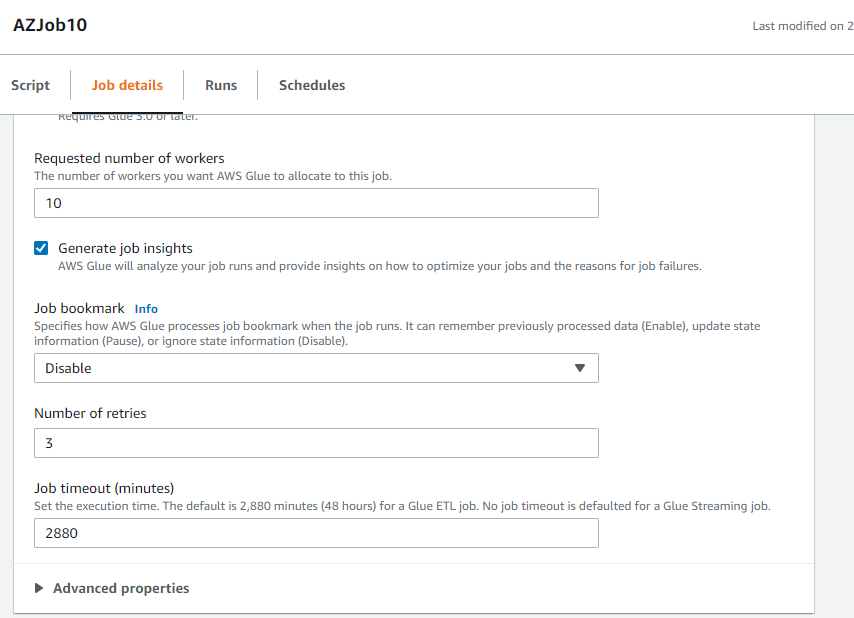

### References


Boto3 IAM API: https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/iam.html

JSON policy element reference: https://docs.aws.amazon.com/IAM/latest/UserGuide/reference_policies_elements.html#Principal_specifying

AWS services that work with IAM: https://docs.aws.amazon.com/IAM/latest/UserGuide/reference_aws-services-that-work-with-iam.html 

Create a role: https://bobbyhadz.com/blog/aws-cli-create-role

AWS Glue - Web API reference: https://docs.aws.amazon.com/glue/latest/webapi/web-api.pdf#WebAPI_Welcome

AWS Glue hands-on: https://hands-on.cloud/working-with-aws-glue-in-python-using-boto3/#h-creating-an-aws-glue-crawler